In [2]:
import glob
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import numpy as np
import sys
import copy
from pathlib import Path
from sympy import *
import pickle
from collections import defaultdict, OrderedDict
import math
import warnings
warnings.filterwarnings('ignore')

%cd ~/recur/notebooks
if '/private/home/sdascoli/recur' in sys.path: sys.path.remove('/private/home/sdascoli/recur')

%load_ext autoreload
%autoreload 2

#sys.path.append('private/home/sdascoli/recur')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':16,
    "lines.linewidth":3.0,
    "savefig.dpi":500,
    'text.latex.preamble':r'\boldmath'
})
plt.rc('axes', grid=True)

cmap=plt.cm.Spectral_r

savedir= '/private/home/sdascoli/recur/figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

/private/home/sdascoli/recur/notebooks


['6.278000e+03', '4.846616e+06', '4.676978e+09', '5.054870e+12', '5.853530e+15', '7.101157e+18']


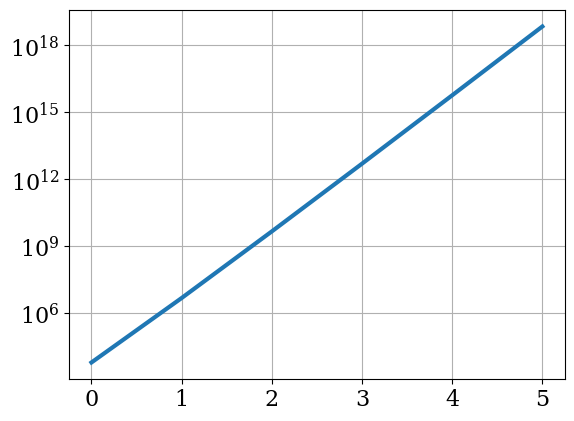

In [3]:
def num_trees(L, p1, p2, n):
    if n==0: return L
    elif n==1: return p2*(L*L+1)/2 + p1*L
    else: return (1/(n+1)) * ((p1+2*L*p2)*(2*n-1)*num_trees(L, p1, p2, n-1) - p1*(n-2)*num_trees(L, p1, p2, n-2))
    #else: return ((p1 + 2*L*p2)*(2*n-1)*num_trees(p1, p2, L, n-1) − p1*(n−2)*num_trees(p1, p2, L, n-2)) / (n+1)
num_trees(1, 0, 1, 5)

x = []
for n in range(1,7):
    x.append(num_trees(32, 4, 12, n))
print(['{:e}'.format(_) for _ in x])
plt.semilogy(x)
plt.show()

In [4]:
def find(array, value):
    idx= np.argwhere(np.array(array)==value)[0,0]
    return idx

def select_runs(runs, params, constraints):
    selected_runs = []
    for irun, run in enumerate(runs):
        keep = True
        for k,v in constraints.items():
            if type(v)!=list:
                v=[v]
            if (not hasattr(run['args'],k)) or (getattr(run['args'],k) not in v):
                keep = False
                break
        if keep:
            selected_runs.append(run)
    selected_params = copy.deepcopy(params)
    for con in constraints:
        selected_params[con]=[constraints[con]]
    return selected_runs, selected_params

def group_runs(runs, finished_only=True):
    runs_grouped = defaultdict(list)
    for run in runs:
        seedless_args = copy.deepcopy(run['args'])
        del(seedless_args.seed)
        del(seedless_args.name)
        if str(seedless_args) not in runs_grouped.keys(): 
            runs_grouped[str(seedless_args)].append(run) # need at least one run
        else:
            if run['finished'] or not finished_only:
                runs_grouped[str(seedless_args)].append(run)
    runs_grouped = list(runs_grouped.values())
    return runs_grouped

def ordered_legend(ax, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*[ (handles[i], labels[i]) for i in sorted(range(len(handles)), key=lambda k: list(map(float,labels))[k])] )
    #ax.legend(handles, labels, **kwargs)
    return handles, labels

def legend_no_duplicates(ax, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[i+1:]]
    ax.legend(*zip(*unique), **kwargs)

In [5]:
def readable_infix(tree):
    infix = tree.infix()
    infix = infix.replace('x_0_','x').replace('x_1_','y').replace('x_2_','z')
    infix = infix.replace('add','+').replace('sub','-').replace('mod','%')
    infix = infix.replace('mul','*').replace('idiv','/').replace('div','/').replace('fabs','abs')
    infix = infix.replace('inv','1/').replace('euler_gamma', 'g').replace('rand','w')
    return infix

def sympy_infix(tree):
    infix = readable_infix(tree)
    n, u1, u2, u3, u4, u5, u6, w, e, g = symbols('n u1 u2 u3 u4 u5 u6 w e g')
    init_printing(use_unicode=True)
    return simplify(eval(infix))
      
def predict(params, series=None, beam_size=None, beam_length_penalty=None, kwargs={}):
    
    if beam_length_penalty is None: beam_length_penalty = args.beam_length_penalty
    if beam_size is None: beam_size = args.beam_size
        
    if series is None:
        generator = RandomRecurrence(params)
        rng = np.random.RandomState(0)
        while True:
            tree, series = generator.generate(rng, **kwargs)
            if series is None: continue
            if np.isnan(np.sum(series)): continue
            break
    else:
        tree = None
    
    x = [env.input_encoder.encode(series)]
    x = [torch.LongTensor([env.input_word2id[w] for w in seq]) for seq in x]
    x, x_len = env.batch_sequences(x)
    x, x_len = x.cuda(), x_len.cuda()
    encoded = encoder("fwd", x=x, lengths=x_len, causal=False)
    gen, _, scores = decoder.generate_beam(
                    encoded.transpose(0, 1),
                    x_len,
                    beam_size=beam_size,
                    length_penalty=beam_length_penalty,
                    early_stopping=args.beam_early_stopping,
                    max_len=args.max_len
    )
    score = scores[0].hyp[0][0]
    for h, hyp in scores[0].hyp:
        prefix = [env.output_id2word[wid] for wid in hyp.tolist()[1:]]
        tree = env.output_encoder.decode(prefix)
        print(tree.infix())
        
    gen = gen.cpu().numpy()[1:-1,0]
    prefix = [env.output_id2word[wid] for wid in gen]
    #pred_tree = env.output_encoder.decode(prefix)[0]
    pred_tree = env.output_encoder.decode(prefix)

    preds = copy.deepcopy(series)
    for i in range(len(series)//args.dimension):
        #if tree: series.append(tree.val(series))
        #preds.append(pred_tree.val(preds))
        if tree: series.extend(tree.val(series))
        preds.extend(pred_tree.val(preds))
    
    return tree, pred_tree, series, preds, score

# Runs

In [25]:
#1631806670 reals
#1632144149 scheduling
#1632300019 precision and nbops
#1632346714 integers
#1632847796 stochasticity
#1633017397 enc/dec hparams
#1633091904 precision and int_base
#1633105818 long run
#1633702046 multidim NEW

runs = []
logs = []
numbers = [1632300019]
numbers = [-1]
base = '/checkpoint/sdascoli/recur/'
#base = '/checkpoint/leventsagun/cnn2transformer/'
numbers = [(base, num) for num in numbers]
#numbers = [('/checkpoint/leventsagun/cnn2transformer/',-2), 
#            ('/checkpoint/sdascoli/cnn2transformer/',-3)]
NaN = np.nan
Infinity = np.nan

for (base, num) in numbers:

    if num<100:
        paths = sorted(glob.glob(base+'*'), key=(lambda x : x.split('/')[-1]))
        paths=[p for p in paths if os.path.isdir(p) and p[-1].isdigit()]
        print(paths)
        path = paths[num]
    else:
        path = base+str(num)
    path += '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = [p for p in dirnames if (os.path.isdir(p) and not p.endswith('__'))]
    print('{} runs found'.format(len(dirnames)))
    fails = 0
    for dirname in dirnames:
        if dirname.endswith('src'): continue
        if len(dirnames)<1000: print(dirname)
        try : 
            run = {}
            args = pickle.load(open(dirname+'/params.pkl', 'rb'))
            run['args'] = args
            run['logs'] = []
            run['num_params'] = []
            f = open(dirname+'/train.log', "r")
            for line in f.readlines():
                if '__log__' in line:
                    run['logs'].append(eval(line[line.find('{'):].rstrip('\n')))
                elif '(encoder)' in line:
                    run['num_params_enc'] = eval(line.split(' ')[-1].rstrip('\n'))
                elif '(decoder)' in line:
                    run['num_params_dec'] = eval(line.split(' ')[-1].rstrip('\n'))
            f.close()
            run['num_params'] = run['num_params_enc']+run['num_params_dec']
            args.output_dir = Path(dirname)
            runs.append(run)
        except Exception as e: 
            print(e)
            print('failed !'.format(dirname))
            fails += 1
    print('{} fails'.format(fails))
    
latest = min([len(run['logs']) for run in runs])-1
print('latest : ',latest)
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    try: params[k] = sorted(list(set(params[k])))
    except: pass

['/checkpoint/sdascoli/recur/1631541989', '/checkpoint/sdascoli/recur/1631542004', '/checkpoint/sdascoli/recur/1631542169', '/checkpoint/sdascoli/recur/1631542323', '/checkpoint/sdascoli/recur/1631542463', '/checkpoint/sdascoli/recur/1631542475', '/checkpoint/sdascoli/recur/1631542596', '/checkpoint/sdascoli/recur/1631543815', '/checkpoint/sdascoli/recur/1631562709', '/checkpoint/sdascoli/recur/1631601402', '/checkpoint/sdascoli/recur/1631805205', '/checkpoint/sdascoli/recur/1631805317', '/checkpoint/sdascoli/recur/1631805382', '/checkpoint/sdascoli/recur/1631806212', '/checkpoint/sdascoli/recur/1631806670', '/checkpoint/sdascoli/recur/1632144149', '/checkpoint/sdascoli/recur/1632300019', '/checkpoint/sdascoli/recur/1632346714', '/checkpoint/sdascoli/recur/1632847796', '/checkpoint/sdascoli/recur/1633016536', '/checkpoint/sdascoli/recur/1633017397', '/checkpoint/sdascoli/recur/1633091904', '/checkpoint/sdascoli/recur/1633105818', '/checkpoint/sdascoli/recur/1633702046']
/checkpoint/sda

# Performance

real_series_True_dimension_1_optimizer_adam_inverse_sqrt,lr=0.0002,warmup_updates=10000 68299318 135 62.28
real_series_True_dimension_2_optimizer_adam_inverse_sqrt,lr=0.0002,warmup_updates=10000 68302909 189 45.35
real_series_True_dimension_3_optimizer_adam_inverse_sqrt,lr=0.0002,warmup_updates=10000 68306500 127 30.49
real_series_True_dimension_1_optimizer_adam_inverse_sqrt,lr=0.0002,warmup_updates=10000_prob_rand_0.05 68299831 349 58.27


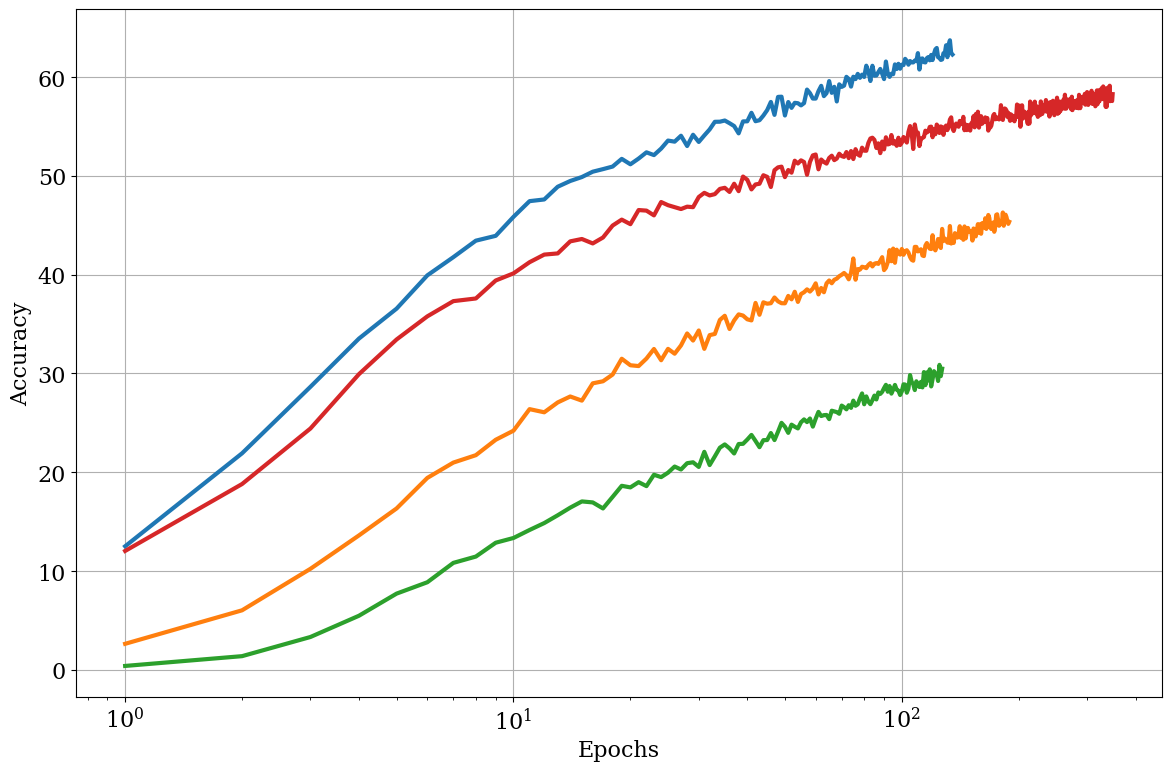

In [28]:
constraints = {
    'real_series':True,
    #'n_enc_layers':4,
    #'n_dec_layers':4,  
    #'prob_rand':0.,
    #'optimizer':"adam_inverse_sqrt,lr=0.0002,warmup_updates=10000"
}
if constraints['real_series']:
    constraints['optimizer']="adam_inverse_sqrt,lr=0.0002,warmup_updates=10000"
else:
    constraints['optimizer']="adam_inverse_sqrt,lr=0.0005,warmup_updates=10000"
selected_runs, selected_params = select_runs(runs, params, constraints)

plt.figure(figsize=(12,8))
for run in selected_runs[:]:
    args = run['args']
    latest = len(run['logs'])
    loss = [run['logs'][t]['valid_recurrence_xe_loss'] for t in range(latest)]
    perfect = [run['logs'][t]['valid_recurrence_perfect'] for t in range(latest)]
    valid = [run['logs'][t]['valid_recurrence_beam_acc'] for t in range(latest)]
    additional = [run['logs'][t]['valid_recurrence_additional_1'] for t in range(latest)]
    if valid: print(Path(args.dump_path).name, run['num_params'], latest, valid[-1])
    plt.plot(range(1,len(valid)+1), valid, label=Path(args.dump_path).name)

#plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xscale('log')

plt.tight_layout()
plt.show()

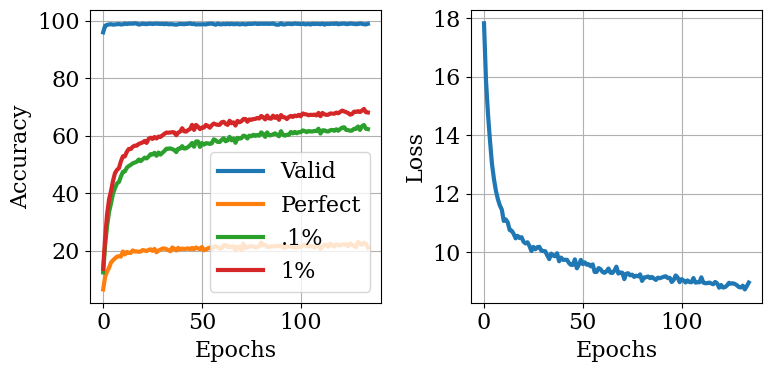

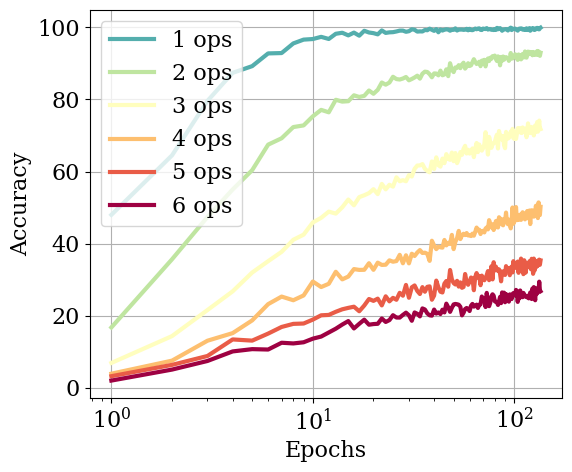

In [19]:
run = selected_runs[0]
args = run['args']

fig, axarr = plt.subplots(1,2,figsize=(8,4))

latest = len(run['logs'])
correct = [run['logs'][t]['valid_recurrence_correct'] for t in range(latest)]
perfect = [run['logs'][t]['valid_recurrence_perfect'] for t in range(latest)]
valid = [run['logs'][t]['valid_recurrence_beam_acc'] for t in range(latest)]
additional = [run['logs'][t]['valid_recurrence_additional_1'] for t in range(latest)]
loss = [run['logs'][t]['valid_recurrence_xe_loss'] for t in range(latest)]
axarr[0].plot(correct, label='Valid')
axarr[0].plot(perfect, label='Perfect')
axarr[0].plot(valid, label='.1%')
axarr[0].plot(additional, label='1%')
axarr[1].plot(loss)
axarr[0].legend()
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Accuracy')
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

##########

plt.figure(figsize=(6,5))
latest = len(run['logs'])
max_ops = args.max_ops*args.dimension
for nb_ops in range(1,max_ops+1):
    try: acc = [run['logs'][t][f'valid_recurrence_beam_acc_{nb_ops}'] for t in range(latest)]
    except: continue
    plt.plot(range(1, len(acc)+1), acc, label=f'{nb_ops} ops', color = cmap(nb_ops/max_ops))

plt.legend()#bbox_to_anchor=(1.05,.9))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xscale('log')

plt.tight_layout()
#plt.savefig(savedir+'acc_nbops_{}.pdf'.format(args.real_series))
plt.show()

# Demonstration

In [36]:
run = selected_runs[3]
#run = runs[0]
args = run['args']

def import_file(full_path_to_module):
    module_dir, module_file = os.path.split(full_path_to_module)
    module_name, module_ext = os.path.splitext(module_file)
    save_cwd = os.getcwd()
    os.chdir(module_dir)
    module_obj = __import__(module_name)
    module_obj.__file__ = full_path_to_module
    globals()[module_name] = module_obj
    os.chdir(save_cwd)
    return module_obj
src = import_file(str(Path(args.dump_path))+'/src')
from src.model import build_modules
from src.envs import ENVS, build_env
from src.trainer import Trainer
from src.evaluator import Evaluator, idx_to_infix
from src.envs.generators import RandomRecurrence

new_args = copy.deepcopy(args)
new_args.multi_gpu=False
new_args.beam_eval=True
new_args.beam_size = 1
new_args.eval_size = 1000
new_args.eval_verbose = 0
new_args.batch_size_eval = 128
new_args.eval_noise = 0
new_args.prob_rand = 0.0001

env = build_env(new_args)
modules = build_modules(env, new_args)

checkpoint_path = os.path.join(new_args.dump_path,'checkpoint.pth')
checkpoint = torch.load(checkpoint_path, map_location="cpu")
new_checkpoint = {}
for k, module in modules.items():
    weights = {k.partition('.')[2]:v for k,v in checkpoint[k].items()}
    module.load_state_dict(weights)
    module.eval()
encoder, decoder = modules["encoder"], modules["decoder"]

In [37]:
trainer = Trainer(modules, env, new_args)
modules = trainer.modules
evaluator = Evaluator(trainer)
scores = evaluator.run_all_evals()
print(scores)
print(scores['valid_recurrence_beam_acc'], scores['valid_recurrence_additional_1'], scores['valid_recurrence_additional_2'])

loop of ufunc does not support argument 0 of type int which has no callable sin method
loop of ufunc does not support argument 0 of type int which has no callable exp method
(34, 'Numerical result out of range')
loop of ufunc does not support argument 0 of type int which has no callable cos method
int too large to convert to float
OrderedDict([('epoch', 349), ('valid_recurrence_xe_loss', 8.192113776445389), ('valid_recurrence_perfect', 21.6), ('valid_recurrence_correct', 99.5), ('valid_recurrence_beam_acc', 66.2), ('valid_recurrence_additional_1', 70.4), ('valid_recurrence_additional_2', 81.9), ('valid_recurrence_beam_acc_1', 100.0), ('valid_recurrence_beam_acc_2', 97.72727272727273), ('valid_recurrence_beam_acc_3', 80.95238095238095), ('valid_recurrence_beam_acc_4', 58.04597701149425), ('valid_recurrence_beam_acc_5', 33.70165745856354), ('valid_recurrence_beam_acc_6', 28.08219178082192)])
66.2 70.4 81.9


# In distribution

((abs(x_0_5) add x_0_6) sub n)
(n mod (n)**2)
abs((n idiv n))
(n)**2
((n add abs(abs(abs(abs(8))))) add 4)
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'' (x_0_2 add ((n)**2 idiv 7))
abs(6)
(n mod -2)
(7 sub (n idiv x_0_2))
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'' ((9)**2 mul 6)


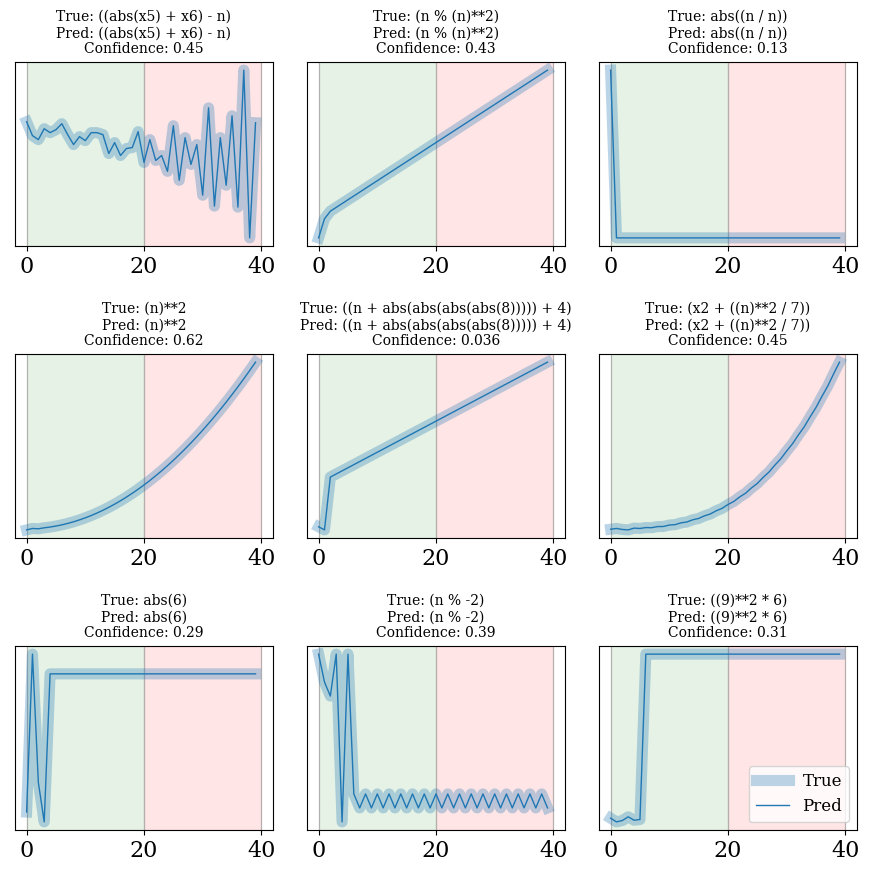

In [17]:
n = 3
use_sympy = False
    
fig, axarr = plt.subplots(n,n,figsize=(n*3,n*3))
n_errors = 0
for i in range(n):
    for j in range(n):
        while True:
            try:
                tree, pred_tree, series, preds, score = predict(args, kwargs={'nb_ops':3, 'length':20})
                confidence = 10**score
                if np.isnan(np.sum(series)): continue
                if np.isnan(np.sum(preds)): continue
                if use_sympy: 
                    pred, true = sympy_infix(pred_tree), sympy_infix(tree)
                else:
                    pred, true = readable_infix(pred_tree), readable_infix(tree)
                #axarr[i,j].plot(series)
                #axarr[i,j].plot(preds, ls='--')
                axarr[i,j].axvspan(0, len(series)//2//args.dimension, alpha=0.1, color='green')
                axarr[i,j].axvspan(len(series)//2//args.dimension, len(series)//args.dimension, alpha=0.1, color='red')
                for dim in range(args.dimension):
                    axarr[i,j].plot(series[dim::args.dimension], color='C%d'%dim, lw=8, alpha=.3, label='True' if dim==0 else '')
                    axarr[i,j].plot(preds [dim::args.dimension], color='C%d'%dim, lw=1, label='Pred' if dim==0 else '')
                break
            except Exception as e:
                print(e, end=' ')
                if n_errors>10: break
                n_errors += 1
        axarr[i,j].set_title(f'True: {true}\nPred: {pred}\nConfidence: {confidence:.2}', fontsize=10)
        #axarr[i,j].set_yscale('symlog')
        #axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])    
axarr[-1,-1].legend(fontsize=12)
        
plt.tight_layout()
plt.savefig(savedir+'plots_{}_dim{}.pdf'.format(args.real_series,args.dimension))
plt.show()

# Out of distribution

((n mul 3) add (n div 10))
(n add (n add (n add (n div 10))))
(n add ((n add n) add (n div 10)))
[93.0, 96.10000000000001, 99.2, 102.3, 105.4] [93.0, 96.1, 99.2, 102.3, 105.4]
0.0


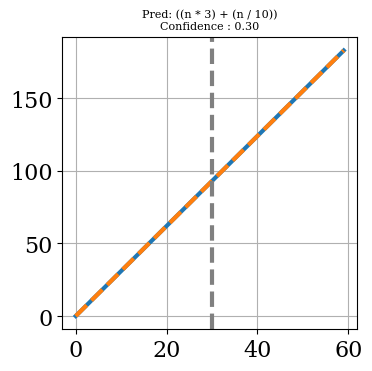

In [64]:
def logistic(n, r, x0):
    if n==0: return x0
    else: prev = logistic(n-1, r, x0)
    return r * prev * (1-prev)

def lcg(n, a, c, mod, seed):
    if n==0: return seed
    else: return (a*lcg(n-1, a, c, mod, seed)+c) % mod
    
def collatz_sequence(n):
    collatz_list=list() #list to store the values of sequence
    while (n!=1) :
        collatz_list.append(n) 
        if (n%2==0) :
            n=n//2
        else:
            n=(3*n)+1
    collatz_list.append(1)  #print 1 in the end   
    return collatz_list

f = lambda n : 3.1*n
length = 60

fig, ax = plt.subplots(1,1,figsize=(4,4))
series = [f(n-1) for n in range(1,length+1)]
#series = [logistic(n, 3, 0.5) for n in range(length)]
#series = [lcg(n, a=8, c=-8, mod=7, seed=1) for n in range(length)]
#series = collatz_sequence(27)[:length]
#series = [1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610]
#series = list(np.array([1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610])*3)
#series = list(torch.randn(30).numpy())
#series = [1,2,4,7,11]
#series = [0, 1, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 21, 21, 21, 21, 21, 21]
#series = list((np.array(series) - np.array([n * np.log(n) for n in range(1,length+1)])).astype(int))
#print(series)

tree, pred_tree, _, preds, score = predict(params, series=series[:length//2], beam_length_penalty=1, beam_size=3)
print(series[length//2:length//2+5],preds[length//2:length//2+5])
print((series[length-1] - preds[length-1])/(length-1))
confidence = 10**score
pred = readable_infix(pred_tree)
ax.plot(series)
ax.plot(preds, ls='--')
#ax.plot([n * np.log(n) for n in range(1,length+1)], ls='--')
ax.axvline(x=len(preds)//2, ls='--', color='grey')
plt.title(f'Pred: {pred}\nConfidence : {confidence:.2f}', fontsize=8)
#plt.yscale('symlog')
#plt.xticks([])
#plt.yticks([])

plt.tight_layout()
plt.show()

((n mul 3) add (n div 10))
(n add (n add (n add (n div 10))))
(n add ((n add n) add (n div 10)))
[93.0, 96.10000000000001, 99.2, 102.3, 105.4] [93.0, 96.1, 99.2, 102.3, 105.4]
0.0


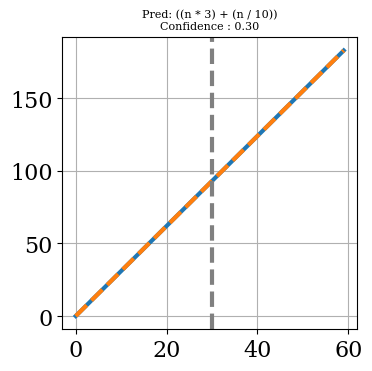

In [64]:
def logistic(n, r, x0):
    if n==0: return x0
    else: prev = logistic(n-1, r, x0)
    return r * prev * (1-prev)

def lcg(n, a, c, mod, seed):
    if n==0: return seed
    else: return (a*lcg(n-1, a, c, mod, seed)+c) % mod
    
def collatz_sequence(n):
    collatz_list=list() #list to store the values of sequence
    while (n!=1) :
        collatz_list.append(n) 
        if (n%2==0) :
            n=n//2
        else:
            n=(3*n)+1
    collatz_list.append(1)  #print 1 in the end   
    return collatz_list

f = lambda n : 3.1*n
length = 60

fig, ax = plt.subplots(1,1,figsize=(4,4))
series = [f(n-1) for n in range(1,length+1)]
#series = [logistic(n, 3, 0.5) for n in range(length)]
#series = [lcg(n, a=8, c=-8, mod=7, seed=1) for n in range(length)]
#series = collatz_sequence(27)[:length]
#series = [1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610]
#series = list(np.array([1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610])*3)
#series = list(torch.randn(30).numpy())
#series = [1,2,4,7,11]
#series = [0, 1, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 21, 21, 21, 21, 21, 21]
#series = list((np.array(series) - np.array([n * np.log(n) for n in range(1,length+1)])).astype(int))
#print(series)

tree, pred_tree, _, preds, score = predict(params, series=series[:length//2], beam_length_penalty=1, beam_size=3)
print(series[length//2:length//2+5],preds[length//2:length//2+5])
print((series[length-1] - preds[length-1])/(length-1))
confidence = 10**score
pred = readable_infix(pred_tree)
ax.plot(series)
ax.plot(preds, ls='--')
#ax.plot([n * np.log(n) for n in range(1,length+1)], ls='--')
ax.axvline(x=len(preds)//2, ls='--', color='grey')
plt.title(f'Pred: {pred}\nConfidence : {confidence:.2f}', fontsize=8)
#plt.yscale('symlog')
#plt.xticks([])
#plt.yticks([])

plt.tight_layout()
plt.show()

# Embeddings

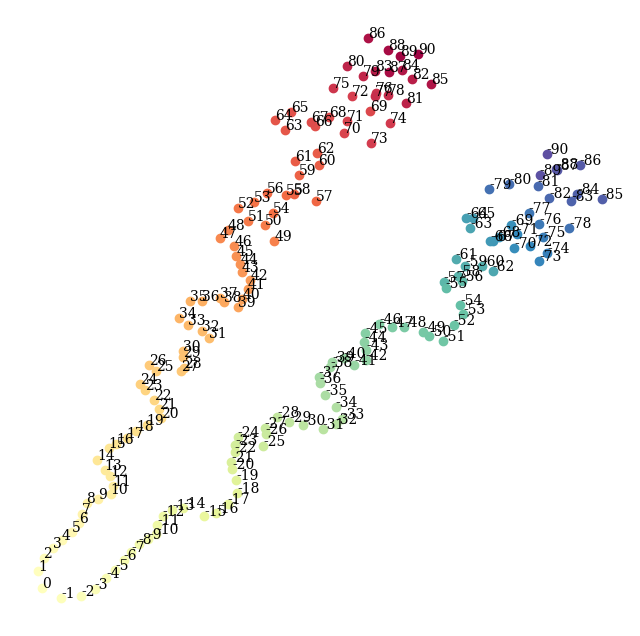

In [38]:
from sklearn.manifold import TSNE

def get_labels_tokens(embeddings, env):
    "Creates and TSNE model and plots it"
    labels = []; tokens = []
    if args.real_series: smallest, largest = -90, 90
    else: smallest, largest = 0, 1000
    for number in range(smallest, largest+1):
        if args.real_series: word = 'E'+str(number-args.float_precision)
        else: word = str(number)
        idx = env.input_word2id[word]
        tokens.append(embeddings[idx])
        labels.append(str(number))
    return labels, tokens

def get_output_labels_tokens(embeddings, env):
    "Creates and TSNE model and plots it"
    labels = []; tokens = []
    for word, idx in env.output_word2id.items():
        tokens.append(embeddings[idx])
        labels.append(word)
    return labels, tokens
            
def tsne_plot_2d(embeddings, env, n_words=200):
    
    labels, tokens = get_labels_tokens(embeddings, env) 
    tsne_model = TSNE( n_components=2, perplexity=40, init='pca', n_iter=2500, random_state=1)
    new_values = tsne_model.fit_transform(tokens)

    x = []; y = []
    for value in new_values:
        x.append(value[0]); y.append(value[1])
        
    plt.figure(figsize=(8, 8)) 
    for i in range(len(x))[:n_words]:
        plt.scatter(x[i],y[i], color=cmap(i/min(n_words, len(x))))
        plt.annotate(labels[i], xy=(x[i], y[i]), fontsize=10)#, xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.axis(False)
    plt.savefig(savedir+'embeddings_{}.pdf'.format(args.real_series))
    plt.show()
       
tsne_plot_2d(encoder.embeddings.weight.cpu().detach().numpy(), env)

<Figure size 1500x1500 with 0 Axes>

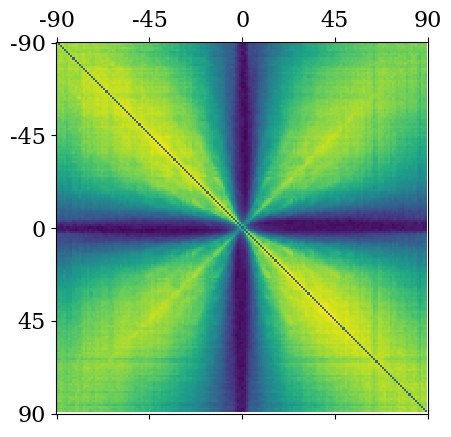

In [39]:
plt.figure(figsize=(15,15))
embeddings = encoder.embeddings.weight.cpu().detach()
if args.real_series: smallest, largest = -90, 90
else: smallest, largest = 0, 1000
similarity = torch.zeros(largest-smallest, largest-smallest)

for i1, w1 in enumerate(range(smallest, largest)):
    if args.real_series: w1 = 'E'+str(w1-args.float_precision)
    for i2, w2 in enumerate(range(smallest, largest)):
        if i1==i2: continue
        if args.real_series: w2 = 'E'+str(w2-args.float_precision)
        j1 = env.input_word2id[str(w1)]
        j2 = env.input_word2id[str(w2)]
        similarity[i1,i2] = torch.dot(embeddings[j1], embeddings[j2])/embeddings[j1].norm()/embeddings[j2].norm()

plt.matshow(similarity)
plt.grid(False)

nticks = 5
ticks = np.linspace(0,len(similarity), nticks)
labels = np.linspace(smallest, largest, nticks).astype(int)
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)

plt.tight_layout()
plt.savefig(savedir+'embedding_similarities_{}.pdf'.format(args.real_series))
plt.show()

# Attention maps

((x_0_3 div n) div (n add x_0_3))


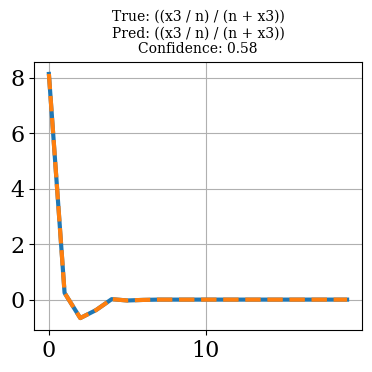

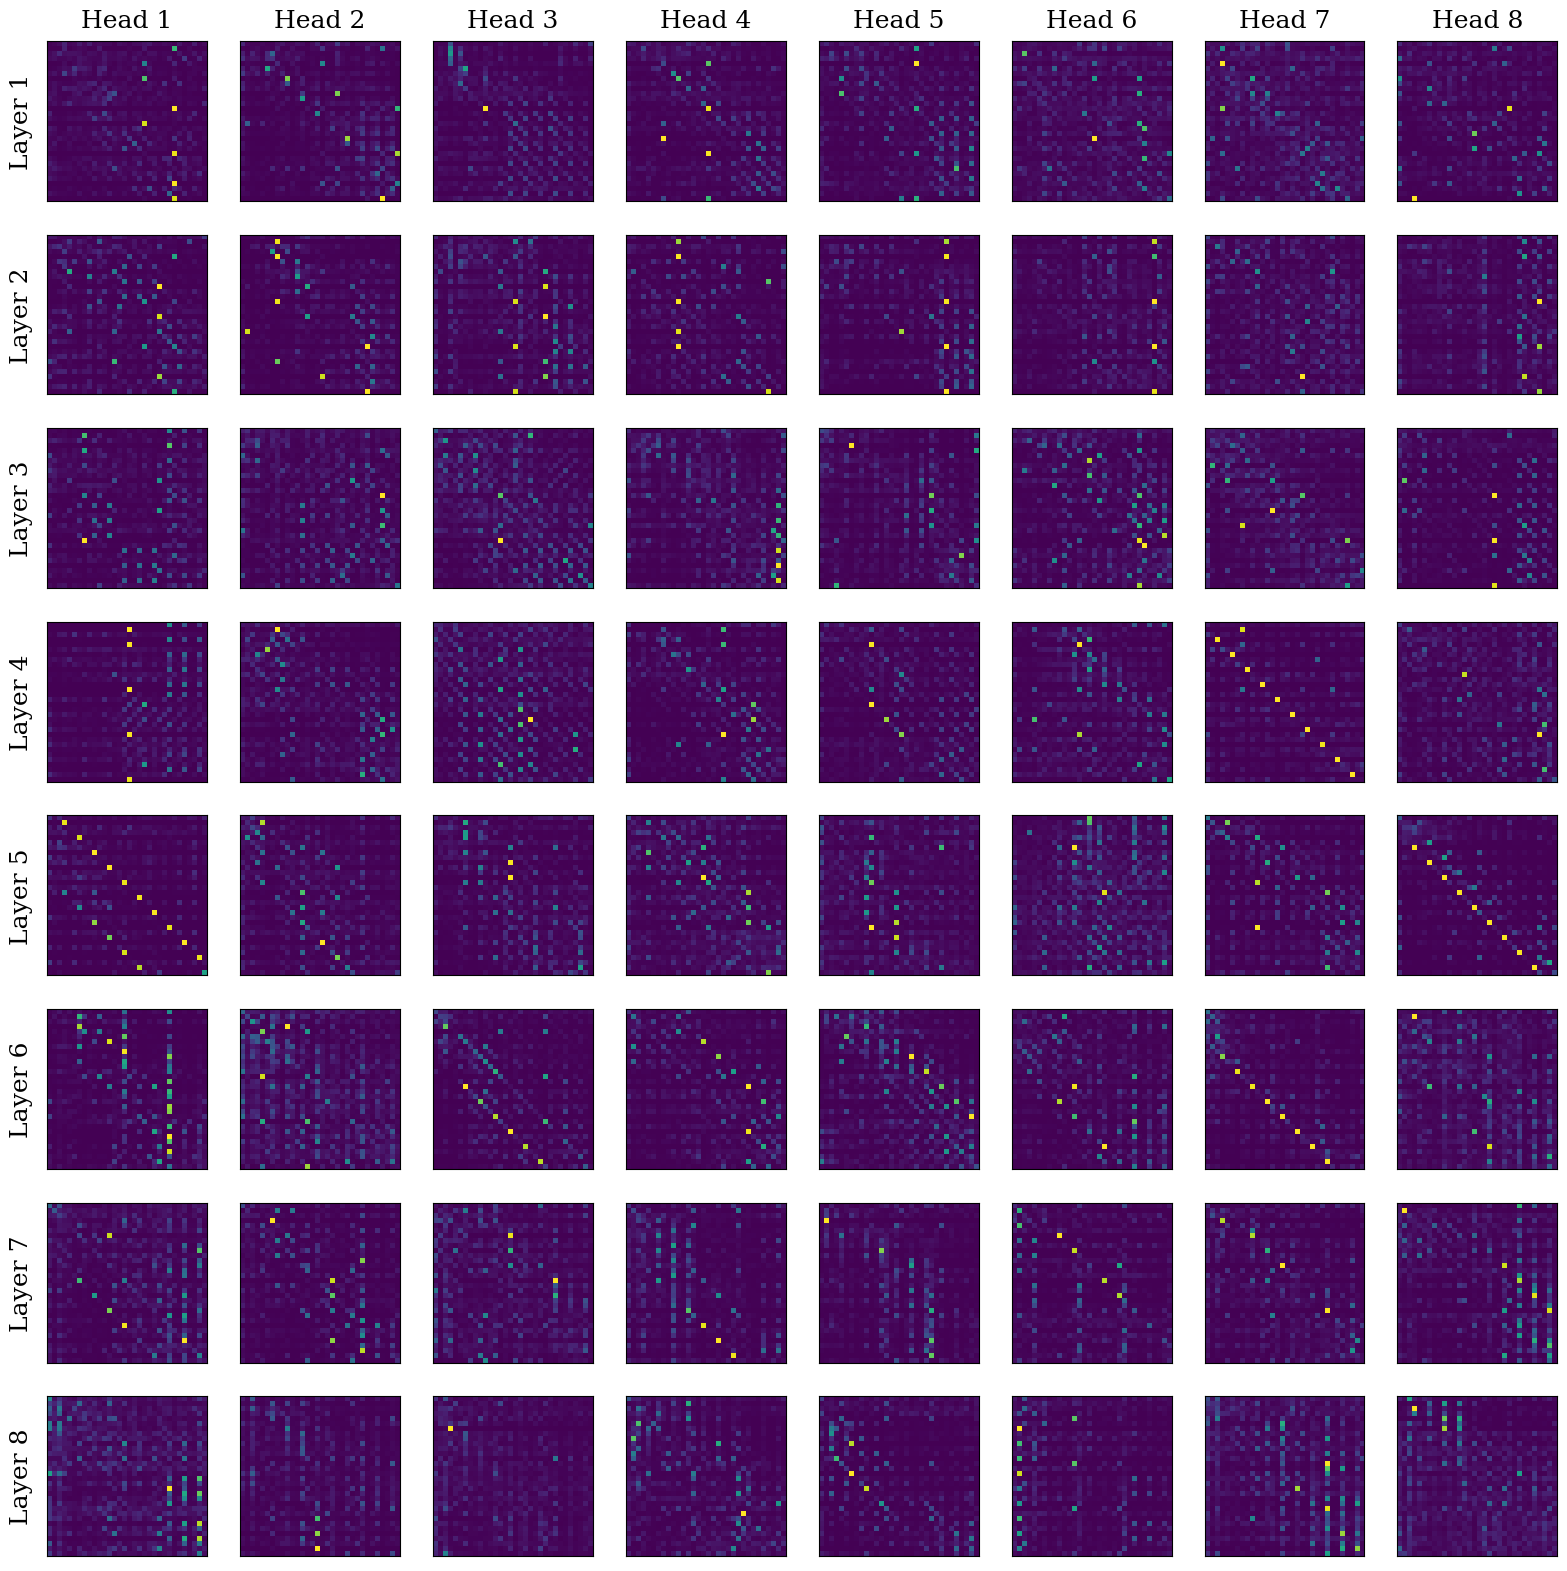

In [55]:
encoder.STORE_OUTPUTS = True

def plot_attention(model):
    
    num_heads = model.n_heads
    num_layers = model.n_layers
    
    new_args = copy.deepcopy(args)
    new_args.series_length = 15
    while True:
        #try:
        tree, pred_tree, series, preds, score = predict(new_args, kwargs={'nb_ops':3, 'deg':3, 'length':10})
        break
        #except Exception as e:
            #print(e, end=' ')
    pred, true = readable_infix(pred_tree), readable_infix(tree)
    separations = [idx for idx, val in enumerate(np.array(env.input_encoder.encode(series[:len(series)//2+1]))) if val in ['+','-']]
            
    plt.figure(figsize=(4,4))
    plt.plot(series)
    plt.plot(preds, ls='--')
    plt.title(f'True: {true}\nPred: {pred}\nConfidence: {confidence:.2}', fontsize=10)
    plt.tight_layout()
    plt.savefig(savedir+'attention_plot_{}.pdf'.format(args.real_series))
        
    fig, axarr = plt.subplots(num_layers, num_heads, figsize=(2*num_heads,2*num_layers), constrained_layout=True)        
        
    for l in range(num_layers):
        module = model.attentions[l]
        scores = module.outputs.squeeze()
        
        for head in range(num_heads):                  
            axarr[l][head].matshow(scores[head])
            
            axarr[l][head].set_xticks([]) 
            axarr[l][head].set_yticks([]) 
            #for val in separations: 
            #    axarr[l][head].axvline(val, color='red', lw=.5)
            #    axarr[l][head].axhline(val, color='red', lw=.5)
                
    cols = [r'Head {}'.format(col+1) for col in range(num_heads)]
    rows = ['Layer {}'.format(row+1) for row in range(num_layers)]
    for icol, col in enumerate(cols):
        axarr[0][icol].set_title(col, fontsize=18, pad=10)
    for irow, row in enumerate(rows):
        axarr[irow][0].set_ylabel(row, fontsize=18, labelpad=10)

    plt.tight_layout()
    plt.savefig(savedir+'attention_{}.pdf'.format(args.real_series))
    plt.show()
    
    return tree, pred_tree, series, preds, score
    
tree, pred_tree, series, preds, score = plot_attention(encoder)

# OEIS

In [78]:
lines = []
with open("/private/home/sdascoli/recur/OEIS.txt", 'r') as f:
    for line in f.readlines():
        x = [int(x) for x in line.split(',')[1:-1]]
        if len(x)>10: lines.append(x)
    
def predict_batch(params, batch, pred_len=3):
        
    x = [env.input_encoder.encode(seq) for seq in batch]
    x = [torch.LongTensor([env.input_word2id[w] for w in seq]) for seq in x]
    x, x_len = env.batch_sequences(x)
    x, x_len = x.cuda(), x_len.cuda()
    encoded = encoder("fwd", x=x, lengths=x_len, causal=False)
    gen, _, scores = decoder.generate_beam(
                    encoded.transpose(0, 1),
                    x_len,
                    beam_size=1,
                    length_penalty=args.beam_length_penalty,
                    early_stopping=args.beam_early_stopping,
                    max_len=args.max_len
    )
    gens = gen.cpu().numpy()[1:-1,:].T
    prefixes = [[env.output_id2word[wid] for wid in gen] for gen in gens]
    pred_trees = [env.output_encoder.decode(prefix) for prefix in prefixes]

    preds = []
    for i, seq in enumerate(batch):
        if not pred_trees[i]: preds.append(None)
        else:
            pred = copy.deepcopy(seq)
            for _ in range(pred_len):
                if pred[-1]>env.params.max_number: break
                pred.extend(pred_trees[i].val(pred))
            preds.append(pred[len(seq):])
    
    return pred_trees, preds

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
#with open('/private/home/sdascoli/recur/OEIS_10.txt', 'w') as f:
#    for line in lines[:2000]:
#        x = ' '.join(env.input_encoder.encode(line[:10]))
#        x += '=SPECIAL\n'
#        f.write(x)

In [79]:
batch_size = 128
seq_len = 10
pred_len = 3

print('{:.0f} batches'.format(len(lines)/batch_size))
corrects = {1:0, 3:0}
for ibatch, batch in enumerate(chunks(lines, batch_size)):
    inputs = [seq[:seq_len] for seq in batch]
    pred_trees, preds = predict_batch(params, inputs, pred_len)
    for i in range(batch_size): 
        pred = preds[i]
        if pred is None: continue
        true = batch[i][seq_len:seq_len+len(preds[i])]
        for key in corrects:
            corrects[key] += int(true[:key]==pred[:key])
        
    if ibatch%10==0: 
        total = (ibatch+1)*batch_size
        print('batch {}: {} {}'.format(ibatch, corrects[1]/total, corrects[3]/total))

2512 batches
batch 0: 0.3046875 0.1796875
batch 10: 0.14914772727272727 0.10227272727272728
batch 20: 0.13616071428571427 0.08742559523809523
batch 30: 0.13306451612903225 0.07862903225806452
batch 40: 0.14310213414634146 0.08174542682926829
batch 50: 0.13648897058823528 0.07598039215686274
batch 60: 0.13601434426229508 0.07466700819672131
batch 70: 0.12852112676056338 0.06921214788732394
batch 80: 0.14130015432098766 0.07880015432098765
batch 90: 0.13925137362637363 0.07503434065934066
batch 100: 0.1328125 0.07100866336633663
batch 110: 0.14949324324324326 0.08319256756756757
batch 120: 0.1581224173553719 0.08832644628099173
batch 130: 0.16525524809160305 0.09834208015267176
batch 140: 0.15913120567375885 0.0929188829787234
batch 150: 0.15593956953642385 0.09085264900662252
batch 160: 0.1578998447204969 0.09282802795031056
batch 170: 0.15926535087719298 0.09333881578947369
batch 180: 0.1582786602209945 0.09176450276243094
batch 190: 0.15825425392670156 0.08965968586387435
batch 200: 0

ValueError: invalid literal for int() with base 10: '<s>'

abs(((n sub x_0_1) idiv (x_0_1 add (n mod 8))))
0[0, 1, 1, 1, 2, 1, 2, 1, 5, 2, 2, 1, 5, 1, 2, 1, 14, 1, 5, 1, 5, 2, 2, 1, 15, 2, 2, 5, 4, 1, 4, 2, 15, 1, 11, 1, 7, 2, 4, 3, 12, 2, 10, 2, 7, 3, 4, 3, 15, 2, 12, 2, 8, 3, 5, 4, 13, 3, 11, 3] [2, 1, 5, 1, 2, 1, 14, 1, 5, 1, 5, 2, 2, 1, 15, 2, 2, 5, 4, 1, 4, 2, 15, 1, 11, 1, 7, 2, 4, 3, 12, 2, 10, 2, 7, 3, 4, 3, 15, 2, 12, 2, 8, 3, 5, 4, 13, 3, 11, 3] 0.24374745459140537


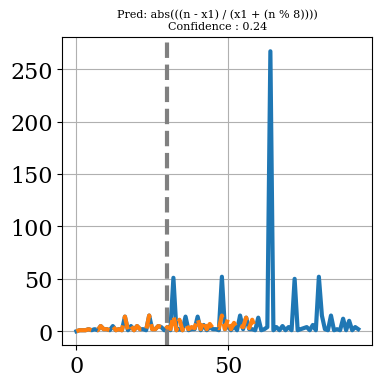

((x_0_3 mul (x_0_1 mul x_0_2)) mod 3)
1[1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1] [2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1] 0.08858747379763328


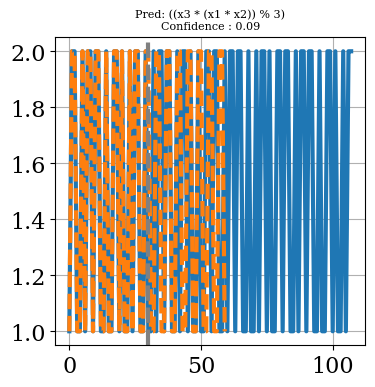

(n idiv (x_0_1 add (n mod abs(x_0_2))))
2[1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 4, 2, 3, 4, 2, 6, 3, 2, 6, 4, 7, 3, 4, 8, 3, 5, 7, 4, 5, 4, 10, 3, 8, 4, 5, 7, 5, 4, 6, 7, 5, 7, 5, 5, 6, 9, 5, 7, 5, 7] [3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 4, 2, 3, 4, 2, 6, 3, 2, 6, 4, 7, 3, 4, 8, 3, 5, 7, 4, 5, 4, 10, 3, 8, 4, 5, 7, 5, 4, 6, 7, 5, 7, 5, 5, 6, 9, 5, 7, 5, 7] 0.18736482894890988


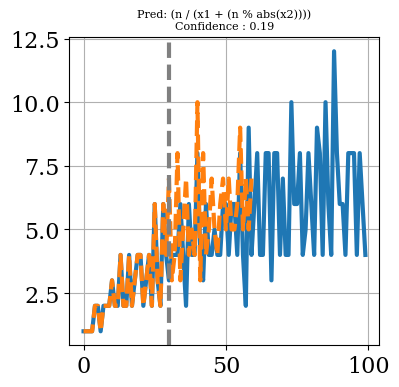

(x_0_1 idiv n)
3[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0.06565036405441078


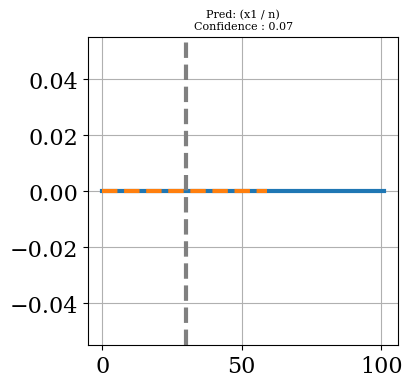

(2 add (x_0_3 mod (n idiv x_0_1)))
4[1, 2, 2, 3, 2, 4, 2, 4, 3, 4, 2, 6, 2, 4, 4, 5, 2, 6, 2, 6, 4, 4, 2, 8, 3, 4, 4, 6, 2, 8, 2, 4, 2, 4, 6, 4, 6, 2, 6, 2, 4, 8, 4, 6, 3, 6, 8, 5, 8, 4, 7, 3, 6, 9, 5, 8, 4, 7, 2, 6] [2, 6, 2, 4, 4, 5, 2, 6, 2, 6, 4, 4, 2, 8, 3, 4, 4, 6, 2, 8, 2, 4, 2, 4, 6, 4, 6, 2, 6, 2, 4, 8, 4, 6, 3, 6, 8, 5, 8, 4, 7, 3, 6, 9, 5, 8, 4, 7, 2, 6] 0.21004240900370383


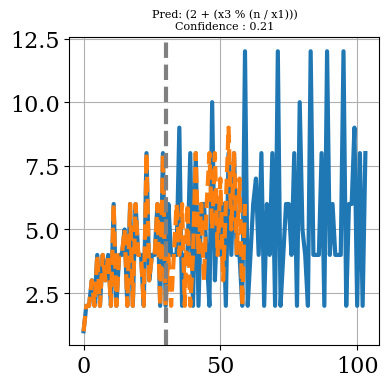

abs(((n mul -6) idiv (x_0_1 add 8)))
5[1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12, 11, 12, 12, 12, 12, 13, 12, 13, 13, 13, 14, 13, 14, 14, 14, 14, 15, 14, 15, 15, 15, 15, 16, 15] [5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12, 11, 12, 12, 12, 12, 13, 12, 13, 13, 13, 14, 13, 14, 14, 14, 14, 15, 14, 15, 15, 15, 15, 16, 15] 0.23628729557941586


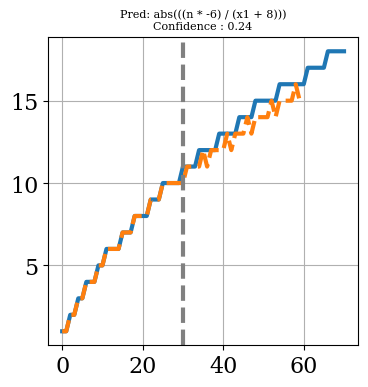

(x_0_1 idiv (n add n))
6[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0.05518085016231058


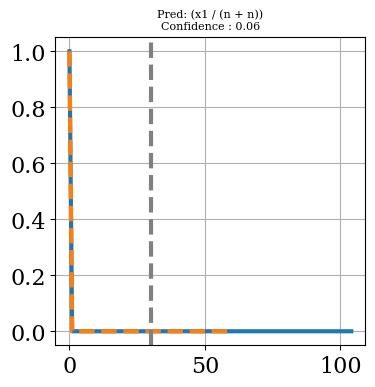

(x_0_2 add ((n add (x_0_2 mod 6)) idiv 4))
7[1, 1, 2, 2, 3, 4, 5, 6, 7, 8, 11, 12, 15, 16, 19, 22, 25, 28, 31, 34, 40, 43, 49, 52, 58, 64, 70, 76, 82, 88, 90, 96, 98, 104, 107, 113, 117, 123, 127, 133, 137, 143, 148, 155, 160, 167, 172, 180, 185, 192, 198, 204, 211, 217, 224, 231, 238, 246, 253, 260] [11, 12, 15, 16, 19, 22, 25, 28, 31, 34, 40, 43, 49, 52, 58, 64, 70, 76, 82, 88, 90, 96, 98, 104, 107, 113, 117, 123, 127, 133, 137, 143, 148, 155, 160, 167, 172, 180, 185, 192, 198, 204, 211, 217, 224, 231, 238, 246, 253, 260] 0.12195284612849604


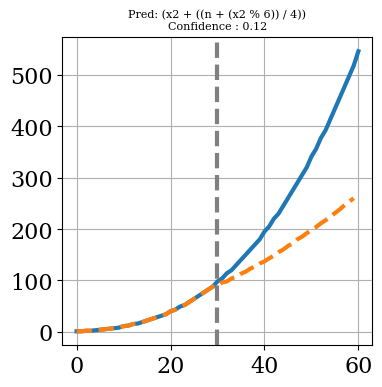

(x_0_1 sub ((x_0_1 add (x_0_1 mod x_0_1)) idiv -5))
8[1, 1, 1, 2, 2, 3, 4, 5, 6, 8, 10, 12, 15, 18, 22, 27, 32, 38, 46, 54, 64, 76, 89, 104, 122, 142, 165, 192, 222, 256, 308, 370, 444, 533, 640, 768, 922, 1107, 1329, 1595, 1914, 2297, 2757, 3309, 3971, 4766, 5720, 6864, 8237, 9885, 11862, 14235, 17082, 20499, 24599, 29519, 35423, 42508, 51010, 61212] [10, 12, 15, 18, 22, 27, 32, 38, 46, 54, 64, 76, 89, 104, 122, 142, 165, 192, 222, 256, 308, 370, 444, 533, 640, 768, 922, 1107, 1329, 1595, 1914, 2297, 2757, 3309, 3971, 4766, 5720, 6864, 8237, 9885, 11862, 14235, 17082, 20499, 24599, 29519, 35423, 42508, 51010, 61212] 0.16739160115751478


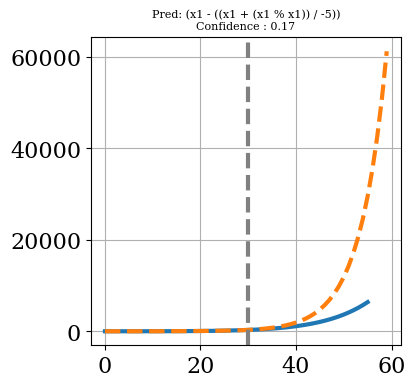

(n sub (((x_0_1 mod -6) sub n) mod x_0_1))
9[1, 1, 2, 2, 4, 2, 6, 4, 6, 4, 10, 4, 12, 6, 8, 8, 16, 6, 18, 8, 12, 10, 22, 8, 20, 12, 18, 12, 28, 8, 24, 14, 26, 18, 32, 10, 34, 8, 32, 18, 26, 34, 18, 32, 28, 36, 20, 38, 24, 26, 26, 28, 50, 10, 50, 14, 46, 24, 44, 34] [10, 4, 12, 6, 8, 8, 16, 6, 18, 8, 12, 10, 22, 8, 20, 12, 18, 12, 28, 8, 24, 14, 26, 18, 32, 10, 34, 8, 32, 18, 26, 34, 18, 32, 28, 36, 20, 38, 24, 26, 26, 28, 50, 10, 50, 14, 46, 24, 44, 34] 0.26759419763737424


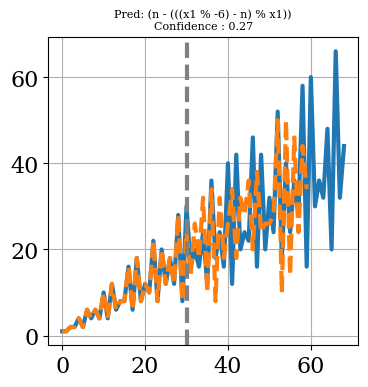

In [80]:
for i, seq in enumerate(lines):
    if i==10: break
    input_seq = seq[:30]
    _, pred_tree, _, preds, score = predict(params, series=input_seq)
    confidence = 10**score
    print(i, end="")
    print(input_seq, preds[10:], confidence)
    plt.figure(figsize=(4,4))
    plt.plot(seq)
    plt.plot(preds, ls='--')
    plt.axvline(x=len(preds)//2, ls='--', color='grey')
    pred = readable_infix(pred_tree)
    plt.title(f'Pred: {pred}\nConfidence : {confidence:.2f}', fontsize=8)
    plt.show()